In [1]:
from neo4j import GraphDatabase, basic_auth
import pandas as pd

In [2]:
# launch neoj4 browser and start an instance of the database
driver = GraphDatabase.driver(
  "bolt://localhost:7687",
  auth=basic_auth("neo4j", "1234"))


In [3]:
cypher_query = '''
MATCH (a:Officer {name:$name})-[r:officer_of|intermediary_of|registered_address*..10]-(b)
RETURN b.name as name LIMIT 20
'''

### Github Example Query

In [4]:
with driver.session(database="neo4j") as session:
    results = session.read_transaction(
        lambda tx: tx.run(cypher_query,
                      name="Ross, Jr. - Wilbur Louis").data())
    
    for record in results:
        print(record['name'])

driver.close()

WL Ross & Co. LLC; 1166 Avenue of the Americas; 25th Floor; New York New York  11036; United States of America
WLR Recovery Fund IV L.P.
WLR IV CLPG L.P.
Walkers Corporate Services Limited, Walker House, 87 Mary Street, George Town; KY1-9005, Grand Cayman; Cayman Islands
Taiyo Greater India Fund GP Ltd.
Clifton House; 75 Fort Street; Grand Cayman KY1-1108; Cayman Islands
Dynap Management Ltd
DYNap Fund SPC
Clifton House; 75 Fort Street; Grand Cayman KY1-1108; Cayman Islands
Seville Holdings Ltd.
Coller International Partners IV-FD, L.P.
OGP IV (Caymans), Ltd.
AEI
Ghada A. Alireza Company, Ltd.
Offshore, Design & Contracting Ltd. ** INCOMPLETE **
ADAMAS INVESTMENTS LTD.
GRANITE HOLDINGS LTD.
Coller International General Partner IV, L.P.
Coller International Partners IV-E, L.P.
WEST BAY BEACH HOLDINGS


### More examples

In [5]:
cypher_query2 = '''
MATCH (o:Officer)-->(e:Entity)<-[:intermediary_of]-(i:Intermediary)
WHERE o.country_codes CONTAINS 'USA' and i.sourceID = 'Panama Papers'
RETURN e.jurisdiction_description AS jurisdiction, count(*) AS number
ORDER BY number DESC LIMIT 10
'''

In [6]:
with driver.session(database="neo4j") as session:
    results = session.run(cypher_query2)

    country = []
    val = []
    #print(results)
    for record in results:
        print(record)
        country.append(record.values()[0])
        val.append(record.values()[1])
        

driver.close()

<Record jurisdiction='British Virgin Islands' number=3441>
<Record jurisdiction='Bahamas' number=186>
<Record jurisdiction='Seychelles' number=178>
<Record jurisdiction='Panama' number=146>
<Record jurisdiction='Samoa' number=98>
<Record jurisdiction='British Anguilla' number=57>
<Record jurisdiction='Nevada' number=23>
<Record jurisdiction='Belize' number=7>
<Record jurisdiction='Hong Kong' number=3>
<Record jurisdiction='United Kingdom' number=3>


In [7]:
import matplotlib.pyplot as plt

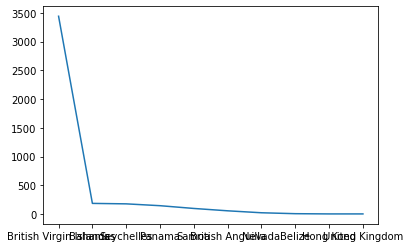

In [8]:
plt.plot(country,val)

In [9]:


def neotocsv(filename, query,d):
    with d.session(database="neo4j") as session:
        results = session.run(query)

        # allows to put header for csv
        i = 0
        #final = []
        file = "data/"+filename
        with open(file, "w+") as f:

            for record in results:

                # write header keys
                if i == 0:
                    i += 1
                    head = ""

                    for k in record.keys():
                        k = str(k).replace(",","")
                        head += k + ","
                    
                    lastCommaIndex = head.rfind(",")
                    newHead = head[:lastCommaIndex] + "\n"
                    f.write(newHead)

                # addes data to CSV
                data = ""
                for v in record.values():
                    v = str(v).replace(",","")
                    data += str(v) + ","

                lastCommaIndex = data.rfind(",")
                newData = data[:lastCommaIndex] + "\n"
                f.write(newData)
                
                #final.append(record.values()[0])
                
                
            

    d.close()

In [11]:
entities = pd.read_csv("data/num_bear.csv")

In [12]:
entities

,entity,num_bearer
0,VELA GAS INVESTMENTS LTD.,492.0
1,GNG LTD.,200.0
2,BOB AGENTS LIMITED,165.0
3,3 DIP S.A.,110.0
4,INGELSA LTD.,107.0
...,...,...
30693,CHORLEY SERVICES LIMITED,1.0
30694,BEAUVIER LTD.,1.0
30695,ATALAMA S.A.,1.0
30696,TETRA INTERNATIONAL LTD.,1.0


In [16]:
name_country = """MATCH p =(e:Entity)
WHERE e.sourceID = "Panama Papers"
RETURN e.name, e.countries"""
neotocsv("country.csv", name_country,driver)

In [17]:
entity_countries = pd.read_csv("data/country.csv")
entity_countries

,e.name,e.countries
0,TIANSHENG INDUSTRY AND TRADING CO. LTD.,Hong Kong
1,NINGBO SUNRISE ENTERPRISES UNITED CO. LTD.,Hong Kong
2,HOTFOCUS CO. LTD.,Hong Kong
3,SKY-BLUE GIFTS & TOYS CO. LTD.,Hong Kong
4,FORTUNEMAKER INVESTMENTS CORPORATION,Hong Kong
...,...,...
213628,MILLION TECH DEVELOPMENT LTD.,Hong Kong
213629,FAITH CONNECTION INTERNATIONAL LTD.,Hong Kong
213630,LARK OVERSEAS INVESTMENT LIMITED,Hong Kong
213631,ASTRA SKIES LIMITED,United Arab Emirates


In [19]:
country_cpi = pd.read_csv("data/cpi2015.csv")
country_cpi

,Country,CPI score 2015,Sources 2015,Standard error 2015
0,Denmark,91,7,2.16
1,New Zealand,91,7,2.32
2,Finland,90,7,1.77
3,Singapore,85,8,2.02
4,Sweden,89,7,1.71
...,...,...,...,...
175,Venezuela,17,7,2.64
176,Yemen,18,6,2.66
177,Syria,18,4,5.66
178,Somalia,8,4,2.32


In [30]:
entities_w_cpi = entity_countries.merge(country_cpi, how='left', left_on="e.countries", right_on ='Country')
entities_w_cpi 

,e.name,e.countries,Country,CPI score 2015,Sources 2015,Standard error 2015
0,TIANSHENG INDUSTRY AND TRADING CO. LTD.,Hong Kong,Hong Kong,75.0,7.0,2.48
1,NINGBO SUNRISE ENTERPRISES UNITED CO. LTD.,Hong Kong,Hong Kong,75.0,7.0,2.48
2,HOTFOCUS CO. LTD.,Hong Kong,Hong Kong,75.0,7.0,2.48
3,SKY-BLUE GIFTS & TOYS CO. LTD.,Hong Kong,Hong Kong,75.0,7.0,2.48
4,FORTUNEMAKER INVESTMENTS CORPORATION,Hong Kong,Hong Kong,75.0,7.0,2.48
...,...,...,...,...,...,...
213628,MILLION TECH DEVELOPMENT LTD.,Hong Kong,Hong Kong,75.0,7.0,2.48
213629,FAITH CONNECTION INTERNATIONAL LTD.,Hong Kong,Hong Kong,75.0,7.0,2.48
213630,LARK OVERSEAS INVESTMENT LIMITED,Hong Kong,Hong Kong,75.0,7.0,2.48
213631,ASTRA SKIES LIMITED,United Arab Emirates,United Arab Emirates,70.0,7.0,5.07


In [31]:
entities_w_cpi.isna().sum()

e.name                     4
e.countries                0
Country                43269
CPI score 2015         43269
Sources 2015           43269
Standard error 2015    43269
dtype: int64

In [40]:
sum(entities_w_cpi["e.countries"]==entities_w_cpi["Country"])

170364

In [44]:
null_countries = entities_w_cpi[entities_w_cpi["Country"].isna()]
null_countries

,e.name,e.countries,Country,CPI score 2015,Sources 2015,Standard error 2015
33,Alvear Investments Limited,Samoa,NaN,NaN,NaN,NaN
41,LONSDALE LIMITED,Liechtenstein,NaN,NaN,NaN,NaN
61,CADELL INVESTMENTS LIMITED,Jersey,NaN,NaN,NaN,NaN
63,HF CAPITAL RISK INC.,Andorra,NaN,NaN,NaN,NaN
89,WINGATE ENTERPRISES LIMITED,Jersey,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
213613,ANWAR MONA HOLDINGS LIMITED,Jersey,NaN,NaN,NaN,NaN
213615,RODRICK HOLDINGS LIMITED,Guernsey,NaN,NaN,NaN,NaN
213624,QUINN FINANCE LTD,Jersey,NaN,NaN,NaN,NaN
213625,CAP DE CREUS SL LIMITED,Andorra,NaN,NaN,NaN,NaN
